In [21]:
from feature_functions import *

In [22]:
controlFiles, patientFiles = fileClassification()

In [31]:
def static_preprocessing(filename): 
    df = pd.read_csv(filename, sep = ";", header = None)

    # split into static and dynamic dataframes
    static_df, _ = staticDynamicSplit(df)

    if static_df.count == 0: 
        return [np.nan for i in list(range(0, 14))]

    static_time = list(static_df[5])

    static_x = static_df[0]
    static_y = static_df[1]
    static_curve = np.array([static_x, static_y])

    # radius & theta calculations
    static_x0 = float(static_x[0])
    static_y0 = float(static_y[0])
    static_r = np.array(((static_x - static_x0)**2 + (static_y - static_y0)**2)**(1/2))
    static_t0 = np.arctan((static_y - static_y0) / (static_x - static_x0+(10**(-10))))
    static_t = np.cumsum(np.abs(np.diff(np.abs(static_t0))))

    static_velocity, static_acceleration, static_jerk, _, _ = smoothCurveFeature(static_curve, 1000, 10000, static_df)
    static_velocity = static_velocity[50: len(static_velocity)-50]
    static_acceleration = static_acceleration[50: len(static_acceleration)-50]
    static_jerk = static_jerk[50: len(static_jerk)-50]

    # radius & theta rate of change features
    static_radius, static_theta, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta = smoothPolarFeature(static_r, static_t, 1000, 1000)
    static_radius = static_radius[50:len(static_radius)-50]
    static_theta = static_theta[50:len(static_theta)-50]
    
    _, _, _, static_curvature, _ = smoothCurveFeature(static_curve, 1000, 100000, static_df)
    static_curvature = static_curvature[50: len(static_curvature)-50] # got rid of last 100 before
    
    static_pressure = static_df[3]
    static_risingIndex, static_fallingIndex = mainSignalThreshold(static_pressure)

    static_pressure_rising = static_pressure[0:static_risingIndex]
    static_pressure_main = static_pressure[static_risingIndex:static_fallingIndex]
    static_pressure_falling = static_pressure[static_fallingIndex:-1]

    static_altitude = static_df[4]

    return (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude)

In [32]:
def dynamic_preprocessing(filename):
    df = pd.read_csv(filename, sep = ";", header = None)

    # split into dynamic and dynamic dataframes
    dynamic_df, _ = staticDynamicSplit(df)

    if dynamic_df.count == 0:
        return [np.nan for i in list(range(0, 14))]

    dynamic_time = list(dynamic_df[5])

    dynamic_x = dynamic_df[0]
    dynamic_y = dynamic_df[1]
    dynamic_curve = np.array([dynamic_x, dynamic_y])

    # radius calculations
    dynamic_x0 = float(dynamic_x[0])
    dynamic_y0 = float(dynamic_y[0])
    dynamic_r = np.array(((dynamic_x-dynamic_x0)**2 + (dynamic_y-dynamic_y0)**2)**(1/2))

    # theta calculations
    dynamic_t0 = np.arctan((dynamic_y-dynamic_y0) / (dynamic_x-dynamic_x0+(10**(-10))))
    dynamic_t = np.cumsum(np.abs(np.diff(np.abs(dynamic_t0))))

    dynamic_velocity, dynamic_acceleration, dynamic_jerk, _, _ = smoothCurveFeature(dynamic_curve, 1000, 10000, dynamic_df)
    dynamic_velocity = dynamic_velocity[50: len(dynamic_velocity)-50]
    dynamic_acceleration = dynamic_acceleration[50: len(dynamic_acceleration)-50]
    dynamic_jerk = dynamic_jerk[50: len(dynamic_jerk)-50]

    (dynamic_radius, dynamic_theta, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta) = smoothPolarFeature(dynamic_r, dynamic_t, 1000, 1000)

    _, _, _, dynamic_curvature, _ = smoothCurveFeature(dynamic_curve, 1000, 100000, dynamic_df)
    dynamic_curvature = dynamic_curvature[50: len(dynamic_curvature)-100]

    dynamic_pressure = dynamic_df[3]
    dynamic_risingIndex, dynamic_fallingIndex = mainSignalThreshold(dynamic_pressure)

    dynamic_pressure_rising = dynamic_pressure[0:dynamic_risingIndex]
    dynamic_pressure_main = dynamic_pressure[dynamic_risingIndex:dynamic_fallingIndex]
    dynamic_pressure_falling = dynamic_pressure[dynamic_fallingIndex:-1]

    dynamic_altitude = dynamic_df[4]

    return (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, 
    dynamic_acceleration, dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, 
    dynamic_drdtheta, dynamic_curvature, dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, 
    dynamic_pressure_rising, dynamic_pressure_main, dynamic_pressure_falling, dynamic_altitude)

In [16]:
def smoothPolarFeature(inputR, inputT, n, smoothing_factor):
    sx = interpolate.UnivariateSpline(np.arange(len(inputR)), inputR, k=4)
    sy = interpolate.UnivariateSpline(np.arange(len(inputT)), inputT, k=4)

    sx.set_smoothing_factor(smoothing_factor)
    sy.set_smoothing_factor(smoothing_factor)

    sxdot = sx.derivative()
    sydot = sy.derivative()
    
    sxdotdot = sxdot.derivative()
    sydotdot = sydot.derivative()
    
    t = np.linspace(0, len(inputR), n)

    radius = sx(t)
    theta = sy(t)

    #calculate velocity
    velocityR = sxdot(t)
    velocityT = sydot(t)

    #calculate acceleration
    accelerationR = sxdotdot(t)
    accelerationT = sydotdot(t)

    #dr/dtheta
    drdtheta = velocityR/velocityT

    # new_curve: interpolated/transformed curve, curv_spline_eval: curvature, curv_dot_eval: rate of change of curvature
    return (radius, theta, velocityR, velocityT, accelerationR, accelerationT, drdtheta)

#r, t, vR, vT, aR, aT, drdtheta = smoothPolarFeature(static_r, static_t, 1000, 1000)

In [18]:
'''
Parameter: filename - file path of patient csv
Returns: static features
'''

def static_calculate(filename):
    # entropy:
    static_x_entropy = entropyCalc(static_x)
    static_y_entropy = entropyCalc(static_y)

    # kinematic features
    # velocity features
    static_velocity_mean = np.mean(static_velocity)
    static_velocity_std = np.std(static_velocity)
    static_velocity_max = max(static_velocity)
    static_velocity_inversion_rate = rateOfInversions(static_velocity, static_time)
    static_nvv = nvv(static_velocity, static_time)

    # acceleration features
    static_acceleration_mean = np.mean(static_acceleration)
    static_acceleration_std = np.std(static_acceleration)
    static_acceleration_max = max(static_acceleration)
    static_acceleration_inversion_rate = rateOfInversions(static_acceleration, static_time)

    # jerk features
    static_jerk_mean = np.mean(static_jerk)
    static_jerk_std = np.std(static_jerk)
    static_jerk_max = max(static_jerk)
    static_jerk_inversion_rate = rateOfInversions(static_jerk, static_time)

    # basic pressure features
    static_pressure_mean = np.mean(static_pressure)
    static_pressure_std = np.std(static_pressure)
    static_pressure_max = max(static_pressure)
    static_pressure_inversion_rate = rateOfInversions(static_pressure, static_time)

    # curvature rate of inversion
    static_curv_inversion_rate = rateOfInversions(static_curvature, static_time)

    # skewness & kurtosis
    static_x_skewness = skew(static_x)
    static_y_skewness = skew(static_y)
    static_x_kurtosis = kurtosis(static_x)
    static_y_kurtosis = kurtosis(static_y)
    
    static_vel_skewness = skew(static_velocity)
    static_vel_kurtosis = kurtosis(static_velocity)

    static_accel_skewness = skew(static_acceleration)
    static_accel_kurtosis = kurtosis(static_acceleration)

    static_jerk_skewness = skew(static_jerk)
    static_jerk_kurtosis = kurtosis(static_jerk)

    static_pressure_skewness = skew(static_pressure)
    static_pressure_kurtosis = kurtosis(static_pressure)

    static_curv_skewness = skew(static_curvature)
    static_curv_kurtosis = kurtosis(static_curvature) 

    '''========================================================================================='''

    # fourier transform pressure
    static_pressure_low_freq, static_pressure_high_freq, static_pressure_bandpass_freq = fourierFreqCalc(static_pressure_main, static_time, 0.12, 0.3, 0.8)

    # fourier transform altitude
    static_altitude_low_freq, static_altitude_high_freq, static_altitude_bandpass_freq = fourierFreqCalc(static_altitude, static_time, 0.12, 0.25, 0.6)

    # pressure vs. time linear regression fit
    static_pressure_reg_main_r2, static_pressure_reg_main_x0, static_pressure_reg_main_x1, static_pressure_reg_main_sumresid = time_regression(static_pressure_main)

    # curvature vs. time logarithmic regression fit
    static_curv_reg_r2, static_curv_reg_x0, static_curv_reg_x1, static_curv_reg_sumresid = nonlinear_time_regression(static_curvature, func_log)

    # velocity vs. time linear regression fit
    static_velocity_reg_r2, static_velocity_reg_x0, static_velocity_reg_x1, static_velocity_reg_sumresid = time_regression(static_velocity)

    # linear regression fit for velocity vs. radius
    static_VR_reg_r2, static_VR_reg_x0, static_VR_reg_x1, static_VR_reg_sumresid = nontime_regression(static_velocity, static_radius)

    # inversely proportional fit for curvature vs. velocity
    static_CV_reg_r2, static_CV_reg_x0, static_CV_reg_x1, static_CV_reg_sumresid = nonlinear_nontime_regression(static_curvature, static_velocity, func_inv)

    # radius vs. theta linear regression fit 
    static_RT_reg_r2, static_RT_reg_x0, static_RT_reg_x1, static_RT_reg_sumresid = nontime_regression(static_radius, static_theta)

    '''========================================================================================='''

    static_rdot_mean = np.mean(static_rdot)
    static_rdot_std = np.std(static_rdot)
    static_tdot_mean = np.mean(static_tdot)
    static_tdot_std = np.std(static_tdot)
    static_rdotdot_mean = np.mean(static_rdotdot)
    static_rdotdot_std = np.std(static_rdotdot)
    static_tdotdot_mean = np.mean(static_tdotdot)
    static_tdotdot_std = np.std(static_tdotdot)
    static_drdtheta_mean = np.mean(static_drdtheta)
    static_drdtheta_std = np.std(static_drdtheta)

    '''========================================================================================='''

    # pressure rising & falling duration/range
    static_pressure_rising_duration = static_time[static_risingIndex] - static_time[0]
    static_pressure_rising_range = static_pressure[static_risingIndex] - static_pressure[0]
    static_pressure_falling_duration = static_time[len(static_time)-1] - static_time[static_fallingIndex]
    static_pressure_falling_range = static_pressure[static_fallingIndex] - static_pressure[len(static_time)-1]

    # overall duration
    static_duration = static_time[-1] - static_time[0]

    return (static_velocity_mean, static_velocity_max, static_velocity_std, static_nvv, static_velocity_inversion_rate,
    static_acceleration_mean, static_acceleration_max, static_acceleration_std, static_acceleration_inversion_rate,
    static_jerk_mean, static_jerk_max, static_jerk_std, static_jerk_inversion_rate,
    static_duration, static_curv_inversion_rate,
    static_pressure_mean, static_pressure_max, static_pressure_std, static_pressure_inversion_rate,
    static_x_entropy, static_y_entropy, static_x_skewness, static_y_skewness, static_x_kurtosis, static_y_kurtosis,
    static_vel_skewness, static_vel_kurtosis, static_accel_skewness, static_accel_kurtosis, static_jerk_skewness, static_jerk_kurtosis,
    static_pressure_skewness, static_pressure_kurtosis, static_curv_skewness, static_curv_kurtosis,
    static_pressure_high_freq, static_pressure_low_freq, static_pressure_bandpass_freq, 
    static_altitude_high_freq, static_altitude_low_freq, static_altitude_bandpass_freq,
    static_pressure_reg_main_r2, static_pressure_reg_main_x0, static_pressure_reg_main_x1, static_pressure_reg_main_sumresid,
    static_curv_reg_r2, static_curv_reg_x0, static_curv_reg_x1, static_curv_reg_sumresid,
    static_velocity_reg_r2, static_velocity_reg_x0, static_velocity_reg_x1, static_velocity_reg_sumresid,
    static_VR_reg_r2, static_VR_reg_x0, static_VR_reg_x1, static_VR_reg_sumresid, 
    static_CV_reg_r2, static_CV_reg_x0, static_CV_reg_x1, static_CV_reg_sumresid, 
    static_RT_reg_r2, static_RT_reg_x0, static_RT_reg_x1, static_RT_reg_sumresid, 
    static_rdot_mean, static_rdot_std, static_tdot_mean, static_tdot_std, 
    static_rdotdot_mean, static_rdotdot_std, static_tdotdot_mean, static_tdotdot_std, 
    static_drdtheta_mean, static_drdtheta_std, 
    static_pressure_rising_duration, static_pressure_rising_range, static_pressure_falling_duration, static_pressure_falling_range)

In [19]:
'''
Parameter: filename - file path of patient csv
Returns: dynamic features
'''

def dynamic_calculate(filename):
    # entropy:
    dynamic_x_entropy = entropyCalc(dynamic_x)
    dynamic_y_entropy = entropyCalc(dynamic_y)

    # kinematic features
    # velocity features
    dynamic_velocity_mean = np.mean(dynamic_velocity)
    dynamic_velocity_std = np.std(dynamic_velocity)
    dynamic_velocity_max = max(dynamic_velocity)
    dynamic_velocity_inversion_rate = rateOfInversions(dynamic_velocity, dynamic_time)
    dynamic_nvv = nvv(dynamic_velocity, dynamic_time)

    # acceleration features
    dynamic_acceleration_mean = np.mean(dynamic_acceleration)
    dynamic_acceleration_std = np.std(dynamic_acceleration)
    dynamic_acceleration_max = max(dynamic_acceleration)
    dynamic_acceleration_inversion_rate = rateOfInversions(dynamic_acceleration, dynamic_time)

    # jerk features
    dynamic_jerk_mean = np.mean(dynamic_jerk)
    dynamic_jerk_std = np.std(dynamic_jerk)
    dynamic_jerk_max = max(dynamic_jerk)
    dynamic_jerk_inversion_rate = rateOfInversions(dynamic_jerk, dynamic_time)

    # basic pressure features
    dynamic_pressure_mean = np.mean(dynamic_pressure)
    dynamic_pressure_std = np.std(dynamic_pressure)
    dynamic_pressure_max = max(dynamic_pressure)
    dynamic_pressure_inversion_rate = rateOfInversions(dynamic_pressure, dynamic_time)

    # curvature rate of inversion
    dynamic_curv_inversion_rate = rateOfInversions(dynamic_curvature, dynamic_time)

    # skewness & kurtosis
    dynamic_x_skewness = skew(dynamic_x)
    dynamic_y_skewness = skew(dynamic_y)
    dynamic_x_kurtosis = kurtosis(dynamic_x)
    dynamic_y_kurtosis = kurtosis(dynamic_y)

    dynamic_vel_skewness = skew(dynamic_velocity)
    dynamic_vel_kurtosis = kurtosis(dynamic_velocity)

    dynamic_accel_skewness = skew(dynamic_acceleration)
    dynamic_accel_kurtosis = kurtosis(dynamic_acceleration)

    dynamic_jerk_skewness = skew(dynamic_jerk)
    dynamic_jerk_kurtosis = kurtosis(dynamic_jerk)

    dynamic_pressure_skewness = skew(dynamic_pressure)
    dynamic_pressure_kurtosis = kurtosis(dynamic_pressure)

    dynamic_curv_skewness = skew(dynamic_curvature)
    dynamic_curv_kurtosis = kurtosis(dynamic_curvature)

    # fourier transform pressure
    dynamic_pressure_low_freq, dynamic_pressure_high_freq = fourierFreqCalc(dynamic_pressure_main, dynamic_time)

    # fourier transform altitude
    dynamic_altitude_low_freq, dynamic_altitude_high_freq = fourierFreqCalc(dynamic_altitude, dynamic_time)

    # pressure vs. time linear regression fit
    dynamic_pressure_reg_main_r2, dynamic_pressure_reg_main_x0, dynamic_pressure_reg_main_x1, dynamic_pressure_reg_main_sumresid = time_regression(dynamic_pressure_main)

    # curvature vs. time logarithmic regression fit
    dynamic_curv_reg_r2, dynamic_curv_reg_x0, dynamic_curv_reg_x1, dynamic_curv_reg_sumresid = nonlinear_time_regression(dynamic_curvature, func_log)

    # velocity vs. time linear regression fit
    dynamic_velocity_reg_r2, dynamic_velocity_reg_x0, dynamic_velocity_reg_x1, dynamic_velocity_reg_sumresid = time_regression(dynamic_velocity)
    
    # linear regression fit for velocity vs. radius
    dynamic_VR_reg_r2, dynamic_VR_reg_x0, dynamic_VR_reg_x1, dynamic_VR_reg_sumresid = nontime_regression(dynamic_velocity, dynamic_radius)

    # inversely proportional fit for curvature vs. velocity
    dynamic_CV_reg_r2, dynamic_CV_reg_x0, dynamic_CV_reg_x1, dynamic_CV_reg_sumresid = nonlinear_nontime_regression(dynamic_curvature, dynamic_velocity)

    # radius vs. theta linear regression fit 
    dynamic_RT_reg_r2, dynamic_RT_reg_x0, dynamic_RT_reg_x1, dynamic_RT_reg_sumresid = nontime_regression(dynamic_radius, dynamic_theta)

    '''========================================================================================='''

    dynamic_rdot_mean = np.mean(dynamic_rdot)
    dynamic_rdot_std = np.std(dynamic_rdot)
    dynamic_tdot_mean = np.mean(dynamic_tdot)
    dynamic_tdot_std = np.std(dynamic_tdot)
    dynamic_rdotdot_mean = np.mean(dynamic_rdotdot)
    dynamic_rdotdot_std = np.std(dynamic_rdotdot)
    dynamic_tdotdot_mean = np.mean(dynamic_tdotdot)
    dynamic_tdotdot_std = np.std(dynamic_tdotdot)
    dynamic_drdtheta_mean = np.mean(dynamic_drdtheta)
    dynamic_drdtheta_std = np.std(dynamic_drdtheta)

    '''========================================================================================='''

    # pressure rising & falling duration/range
    dynamic_pressure_rising_duration = dynamic_time[dynamic_risingIndex] - dynamic_time[0]
    dynamic_pressure_rising_range = dynamic_pressure[dynamic_risingIndex] - dynamic_pressure[0]
    dynamic_pressure_falling_duration = dynamic_time[len(dynamic_time)-1] - dynamic_time[dynamic_fallingIndex]
    dynamic_pressure_falling_range = dynamic_pressure[dynamic_fallingIndex] - dynamic_pressure[len(dynamic_time)-1]

    # overall duration
    dynamic_duration = dynamic_time[-1] - dynamic_time[0]

    return (dynamic_velocity_mean, dynamic_velocity_max, dynamic_velocity_std, dynamic_nvv, dynamic_velocity_inversion_rate,
    dynamic_acceleration_mean, dynamic_acceleration_max, dynamic_acceleration_std, dynamic_acceleration_inversion_rate,
    dynamic_jerk_mean, dynamic_jerk_max, dynamic_jerk_std, dynamic_jerk_inversion_rate,
    dynamic_duration, dynamic_curv_inversion_rate,
    dynamic_pressure_mean, dynamic_pressure_max, dynamic_pressure_std, dynamic_pressure_inversion_rate,
    dynamic_x_entropy, dynamic_y_entropy, dynamic_x_skewness, dynamic_y_skewness, dynamic_x_kurtosis, dynamic_y_kurtosis,
    dynamic_vel_skewness, dynamic_vel_kurtosis, dynamic_accel_skewness, dynamic_accel_kurtosis, dynamic_jerk_skewness, dynamic_jerk_kurtosis,
    dynamic_pressure_skewness, dynamic_pressure_kurtosis, dynamic_curv_skewness, dynamic_curv_kurtosis,
    dynamic_pressure_high_freq, dynamic_pressure_low_freq, dynamic_altitude_high_freq, dynamic_altitude_low_freq,
    dynamic_pressure_reg_main_r2, dynamic_pressure_reg_main_x0, dynamic_pressure_reg_main_x1, dynamic_pressure_reg_main_sumresid,
    dynamic_curv_reg_r2, dynamic_curv_reg_x0, dynamic_curv_reg_x1, dynamic_curv_reg_sumresid,
    dynamic_velocity_reg_r2, dynamic_velocity_reg_x0, dynamic_velocity_reg_x1, dynamic_velocity_reg_sumresid,
    dynamic_VR_reg_r2, dynamic_VR_reg_x0, dynamic_VR_reg_x1, dynamic_VR_reg_sumresid, 
    dynamic_CV_reg_r2, dynamic_CV_reg_x0, dynamic_CV_reg_x1, dynamic_CV_reg_sumresid, 
    dynamic_RT_reg_r2, dynamic_RT_reg_x0, dynamic_RT_reg_x1, dynamic_RT_reg_sumresid, 
    dynamic_rdot_mean, dynamic_rdot_std, dynamic_tdot_mean, dynamic_tdot_std, 
    dynamic_rdotdot_mean, dynamic_rdotdot_std, dynamic_tdotdot_mean, dynamic_tdotdot_std, 
    dynamic_drdtheta_mean, dynamic_drdtheta_std, 
    dynamic_pressure_rising_duration, dynamic_pressure_rising_range, dynamic_pressure_falling_duration, dynamic_pressure_falling_range)

In [33]:
# CALCULATE ALL STATIC FEATURES AND PUT INTO DATAFRAME

static_subject_id = [] 
static_category = [] 
static_mean_vel = [] 
static_max_vel = [] 
static_vel_std = []
static_nvv = []  
static_vel_niv = [] #rate 
static_mean_accel = [] 
static_max_accel = [] 
static_std_accel = [] 
static_nia = [] #rate 
static_mean_jerk = []  
static_max_jerk = [] 
static_std_jerk = [] 
static_nij = [] #rate 
static_duration = [] 
static_nic = [] 
static_mean_pressure = [] 
static_max_pressure = [] 
static_std_pressure = [] 
static_rate_ip = [] 
static_x_entropy = [] 
static_y_entropy = [] 
static_x_skewness = [] 
static_y_skewness = [] 
static_x_kurtosis = [] 
static_y_kurtosis = [] 
static_vel_skewness = [] 
static_vel_kurtosis = [] 
static_accel_skewness = [] 
static_accel_kurtosis = [] 
static_jerk_skewness = [] 
static_jerk_kurtosis = [] 
static_pressure_skewness = [] 
static_pressure_kurtosis = [] 
static_curv_skewness = [] 
static_curv_kurtosis = [] 
static_pressure_high_freq = [] 
static_pressure_low_freq = [] 
static_pressure_bandpass_freq = [] 
static_altitude_high_freq = [] 
static_altitude_low_freq = [] 
static_altitude_bandpass_freq = [] 
static_pressure_reg_r2 = [] 
static_pressure_reg_x0 = [] 
static_pressure_reg_x1 = [] 
static_pressure_reg_sumresids = [] 
static_curv_reg_r2 = [] 
static_curv_reg_x0 = [] 
static_curv_reg_x1 = [] 
static_curv_reg_sumresids = [] 
static_vel_reg_r2 = [] 
static_vel_reg_x0 = [] 
static_vel_reg_x1 = [] 
static_vel_reg_sumresids = [] 

static_VR_reg_r2 = [] 
static_VR_reg_x0 = [] 
static_VR_reg_x1 = [] 
static_VR_reg_sumresids = [] 
static_CV_reg_r2 = [] 
static_CV_reg_x0 = [] 
static_CV_reg_x1 = [] 
static_CV_reg_sumresids = [] 
static_RT_reg_r2 = [] 
static_RT_reg_x0 = [] 
static_RT_reg_x1 = [] 
static_RT_reg_sumresids = [] 
static_rdot_mean = [] 
static_rdot_std = [] 
static_tdot_mean = [] 
static_tdot_std = [] 
static_rdotdot_mean = [] 
static_rdotdot_std = [] 
static_tdotdot_mean = [] 
static_tdotdot_std = [] 
static_drdtheta_mean = [] 
static_drdtheta_std = [] 

static_pressure_rising_duration = [] 
static_pressure_rising_range = [] 
static_pressure_falling_duration = []
static_pressure_falling_range = [] 

for filename in controlFiles:
    print(filename)
    # retrieve all preprocessed data
    
    (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude) = static_preprocessing(filename)

    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = static_calculate(filename)

    # 0 is for control
    static_category.append(0)
    static_subject_id.append(filename)
    static_mean_vel.append(a)
    static_max_vel.append(b)
    static_vel_std.append(c)
    static_nvv.append(d)
    static_vel_niv.append(e) # rate
    static_mean_accel.append(f)
    static_max_accel.append(g)
    static_std_accel.append(h)
    static_nia.append(i) #rate
    static_mean_jerk.append(j)
    static_max_jerk.append(k)
    static_std_jerk.append(l)
    static_nij.append(m) #rate
    static_duration.append(n)
    static_nic.append(o)
    static_mean_pressure.append(p)
    static_max_pressure.append(q)
    static_std_pressure.append(r)
    static_rate_ip.append(s)
    static_x_entropy.append(t)
    static_y_entropy.append(u)
    static_x_skewness.append(v)
    static_y_skewness.append(w)
    static_x_kurtosis.append(x)
    static_y_kurtosis.append(y)
    static_vel_skewness.append(z)
    static_vel_kurtosis.append(a1)
    static_accel_skewness.append(b1)
    static_accel_kurtosis.append(c1)
    static_jerk_skewness.append(d1)
    static_jerk_kurtosis.append(e1)
    static_pressure_skewness.append(f1)
    static_pressure_kurtosis.append(g1)
    static_curv_skewness.append(h1)
    static_curv_kurtosis.append(i1)
    static_pressure_high_freq.append(j1)
    static_pressure_low_freq.append(k1)
    static_pressure_bandpass_freq.append(l1)
    static_altitude_high_freq.append(m1)
    static_altitude_low_freq.append(n1)
    static_altitude_bandpass_freq.append(o1)
    static_pressure_reg_r2.append(p1)
    static_pressure_reg_x0.append(q1)
    static_pressure_reg_x1.append(r1)
    static_pressure_reg_sumresids.append(s1)
    static_curv_reg_r2.append(t1)
    static_curv_reg_x0.append(u1)
    static_curv_reg_x1.append(v1)
    static_curv_reg_sumresids.append(w1)
    static_vel_reg_r2.append(x1)
    static_vel_reg_x0.append(y1)
    static_vel_reg_x1.append(z1)
    static_vel_reg_sumresids.append(a2)

    static_VR_reg_r2.append(b2)
    static_VR_reg_x0.append(c2)
    static_VR_reg_x1.append(d2)
    static_VR_reg_sumresids.append(e2)
    static_CV_reg_r2.append(f2)
    static_CV_reg_x0.append(g2)
    static_CV_reg_x1.append(h2)
    static_CV_reg_sumresids.append(i2)
    static_RT_reg_r2.append(j2)
    static_RT_reg_x0.append(k2)
    static_RT_reg_x1.append(l2)
    static_RT_reg_sumresids.append(m2)
    static_rdot_mean.append(n2)
    static_rdot_std.append(o2)
    static_tdot_mean.append(p2)
    static_tdot_std.append(q2)
    static_rdotdot_mean.append(r2)
    static_rdotdot_std.append(s2)
    static_tdotdot_mean.append(t2)
    static_tdotdot_std.append(u2)
    static_drdtheta_mean.append(v2)
    static_drdtheta_std.append(w2)

    static_pressure_rising_duration.append(x2)
    static_pressure_rising_range.append(y2)
    static_pressure_falling_duration.append(z2)
    static_pressure_falling_range.append(a3)

    
for filename in patientFiles:
    print(filename)
    # retrieve all preprocessed data
    (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude) = static_preprocessing(filename)
    
    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = static_calculate(filename)

    # 1 is for patient
    static_category.append(1)
    static_subject_id.append(filename)
    static_mean_vel.append(a)
    static_max_vel.append(b)
    static_vel_std.append(c)
    static_nvv.append(d)
    static_vel_niv.append(e) # rate
    static_mean_accel.append(f)
    static_max_accel.append(g)
    static_std_accel.append(h)
    static_nia.append(i) #rate
    static_mean_jerk.append(j)
    static_max_jerk.append(k)
    static_std_jerk.append(l)
    static_nij.append(m) #rate
    static_duration.append(n)
    static_nic.append(o)
    static_mean_pressure.append(p)
    static_max_pressure.append(q)
    static_std_pressure.append(r)
    static_rate_ip.append(s)
    static_x_entropy.append(t)
    static_y_entropy.append(u)
    static_x_skewness.append(v)
    static_y_skewness.append(w)
    static_x_kurtosis.append(x)
    static_y_kurtosis.append(y)
    static_vel_skewness.append(z)
    static_vel_kurtosis.append(a1)
    static_accel_skewness.append(b1)
    static_accel_kurtosis.append(c1)
    static_jerk_skewness.append(d1)
    static_jerk_kurtosis.append(e1)
    static_pressure_skewness.append(f1)
    static_pressure_kurtosis.append(g1)
    static_curv_skewness.append(h1)
    static_curv_kurtosis.append(i1)
    static_pressure_high_freq.append(j1)
    static_pressure_low_freq.append(k1)
    static_pressure_bandpass_freq.append(l1)
    static_altitude_high_freq.append(m1)
    static_altitude_low_freq.append(n1)
    static_altitude_bandpass_freq.append(o1)
    static_pressure_reg_r2.append(p1)
    static_pressure_reg_x0.append(q1)
    static_pressure_reg_x1.append(r1)
    static_pressure_reg_sumresids.append(s1)
    static_curv_reg_r2.append(t1)
    static_curv_reg_x0.append(u1)
    static_curv_reg_x1.append(v1)
    static_curv_reg_sumresids.append(w1)
    static_vel_reg_r2.append(x1)
    static_vel_reg_x0.append(y1)
    static_vel_reg_x1.append(z1)
    static_vel_reg_sumresids.append(a2)

    static_VR_reg_r2.append(b2)
    static_VR_reg_x0.append(c2)
    static_VR_reg_x1.append(d2)
    static_VR_reg_sumresids.append(e2)
    static_CV_reg_r2.append(f2)
    static_CV_reg_x0.append(g2)
    static_CV_reg_x1.append(h2)
    static_CV_reg_sumresids.append(i2)
    static_RT_reg_r2.append(j2)
    static_RT_reg_x0.append(k2)
    static_RT_reg_x1.append(l2)
    static_RT_reg_sumresids.append(m2)
    static_rdot_mean.append(n2)
    static_rdot_std.append(o2)
    static_tdot_mean.append(p2)
    static_tdot_std.append(q2)
    static_rdotdot_mean.append(r2)
    static_rdotdot_std.append(s2)
    static_tdotdot_mean.append(t2)
    static_tdotdot_std.append(u2)
    static_drdtheta_mean.append(v2)
    static_drdtheta_std.append(w2)

    static_pressure_rising_duration.append(x2)
    static_pressure_rising_range.append(y2)
    static_pressure_falling_duration.append(z2)
    static_pressure_falling_range.append(a3)

df_all_features_static = pd.DataFrame({'Static Subject ID': static_subject_id, 'Category': static_category,
'Mean Velocity': static_mean_vel, 'Max Velocity': static_max_vel, 'Velocity Std': static_vel_std, 'NVV': static_nvv, 'NIV': static_vel_niv,
'Mean Acceleration': static_mean_accel, 'Max Acceleration': static_max_accel, 'Accleration Std': static_std_accel, 'NIA': static_nia,
'Mean Jerk': static_mean_jerk, 'Max Jerk': static_max_jerk, 'Jerk Std': static_std_jerk, 'NIJ': static_nij, 
'Duration': static_duration, 'NIC': static_nic,
'Mean Pressure': static_mean_pressure, 'Max Pressure': static_max_pressure, 'Pressure Std': static_std_pressure, 'Rate of Inversion in Pressure': static_rate_ip,
'X Entropy': static_x_entropy, 'Y Entropy': static_y_entropy, 
'X Skewness': static_x_skewness, 'Y Skewness': static_y_skewness, 'X Kurtosis': static_x_kurtosis, 'Y Kurtosis': static_y_kurtosis,
'Vel Skewness': static_vel_skewness, 'Vel Kurtosis': static_vel_kurtosis, 'Accel Skewness': static_accel_skewness, 'Accel Kurtosis': static_accel_kurtosis,
'Jerk Skewness': static_jerk_skewness, 'Jerk Kurtosis': static_jerk_kurtosis, 
'Pressure Skewness': static_pressure_skewness, 'Pressure Kurtosis': static_pressure_kurtosis,
'Curvature Skewness': static_curv_skewness, 'Curvature Kurtosis': static_curv_kurtosis,
'Pressure High Freq': static_pressure_high_freq, 'Pressure Low Freq': static_pressure_low_freq, 'Pressure Bandpass Freq': static_pressure_bandpass_freq,
'Altitude High Freq': static_altitude_high_freq, 'Altitude Low Freq': static_altitude_low_freq, 'Altitude Bandpass Freq': static_altitude_bandpass_freq,
'Pressure Reg R^2': static_pressure_reg_r2, 'Pressure Reg x0': static_pressure_reg_x0, 'Pressure Reg x1': static_pressure_reg_x1, 'Pressure Reg SumResids': static_pressure_reg_sumresids,
'Curv Reg R^2': static_curv_reg_r2, 'Curv Reg x0': static_curv_reg_x0, 'Curv Reg x1': static_curv_reg_x1, 'Curv Reg SumResids': static_curv_reg_sumresids,
'Vel Reg R^2': static_vel_reg_r2, 'Vel Reg x0': static_vel_reg_x0, 'Vel Reg x1': static_vel_reg_x1, 'Vel Reg SumResids': static_vel_reg_sumresids,
'VR Reg R^2': static_VR_reg_r2, 'VR Reg x0': static_VR_reg_x0, 'VR Reg x1': static_VR_reg_x1, 'VR Reg SumResids': static_VR_reg_sumresids, 
'CV Reg R^2': static_CV_reg_r2, 'CV Reg x0': static_CV_reg_x0, 'CV Reg x1': static_CV_reg_x1, 'CV Reg SumResids': static_CV_reg_sumresids, 
'RT Reg R^2': static_RT_reg_r2, 'RT Reg x0': static_RT_reg_x0, 'RT Reg x1': static_RT_reg_x1, 'RT Reg SumResids': static_RT_reg_sumresids, 
'R Dot Mean': static_rdot_mean, 'R Dot STD': static_rdot_std, 'T Dot Mean': static_tdot_mean, 'T Dot STD': static_tdot_std, 
'R dotdot Mean': static_rdotdot_mean, 'R dotdot STD': static_rdotdot_std, 'T dotdot Mean': static_tdotdot_mean, 'T dotdot STD': static_tdotdot_std, 
'drdtheta Mean': static_drdtheta_mean, 'drdtheta STD': static_drdtheta_std, 
'Pressure Rising Duration': static_pressure_rising_duration, 'Pressure Rising Range': static_pressure_rising_range,
'Pressure Falling Duration': static_pressure_falling_duration, 'Pressure Falling Range': static_pressure_falling_range})

/work/ParkinsonHW/C_0001.txt
/work/feature_functions.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:189: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  logprob = kde.score_samples(data[:, None])
/work/feature_functions.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:189: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be re

In [9]:
saving_filename = 'Static_HW_features.csv'
df_all_features_static.to_csv(saving_filename, index = False, header=True)

![Picture title](image-20210411-135602.png)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


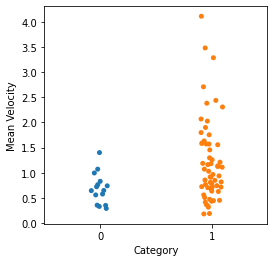

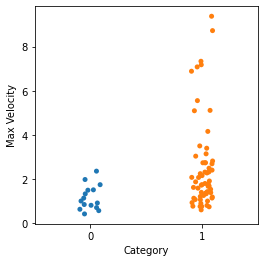

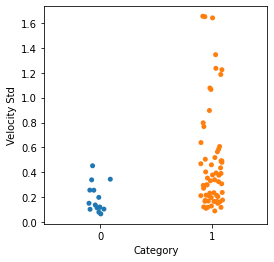

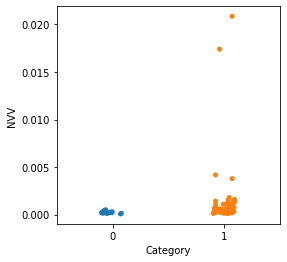

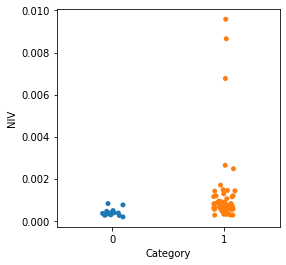

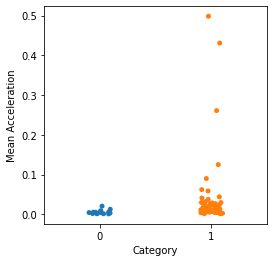

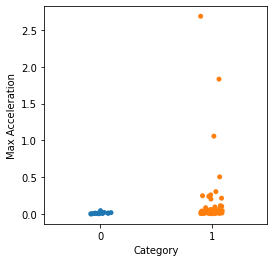

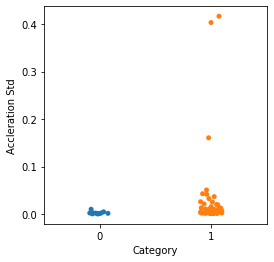

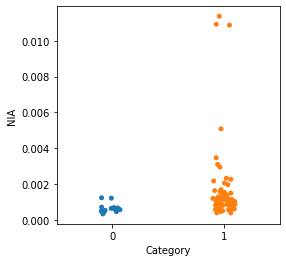

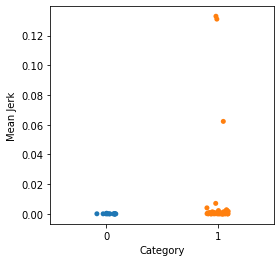

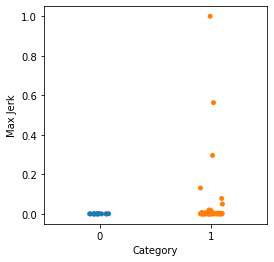

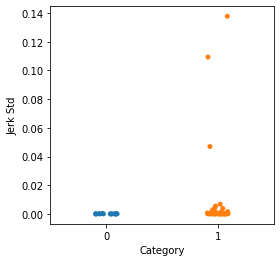

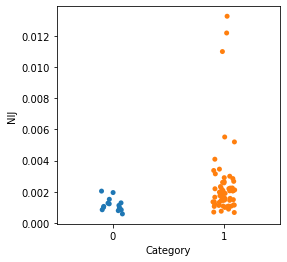

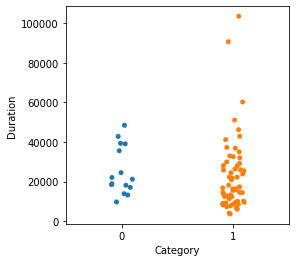

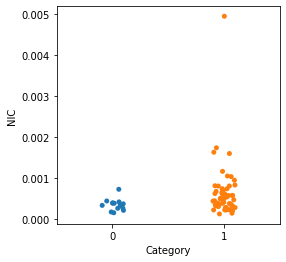

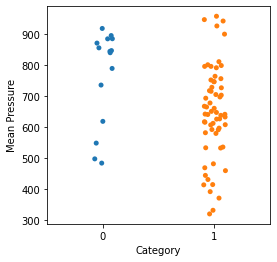

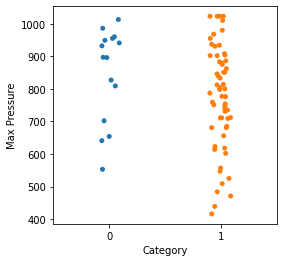

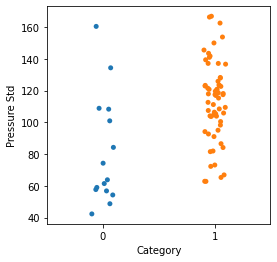

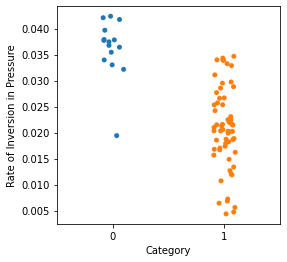

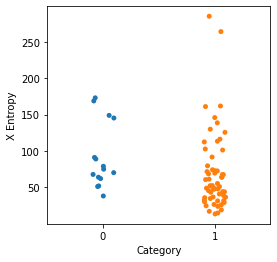

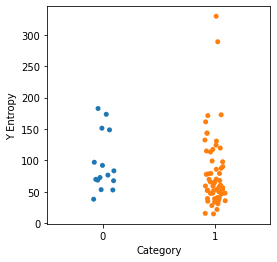

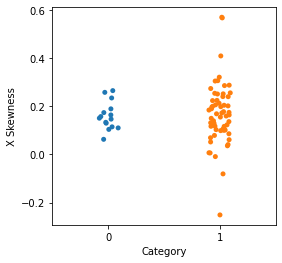

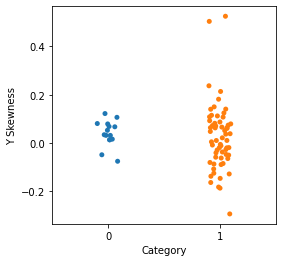

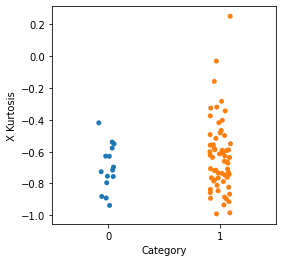

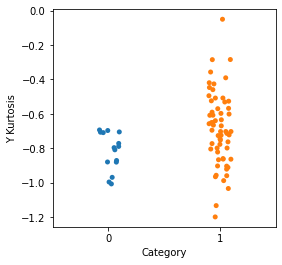

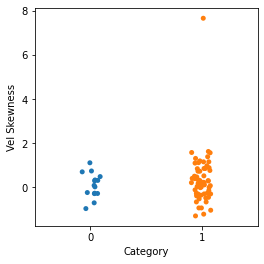

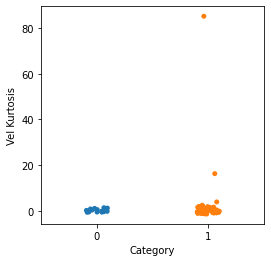

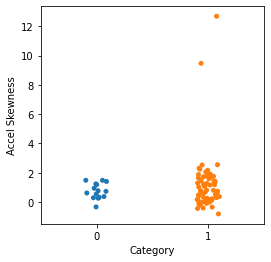

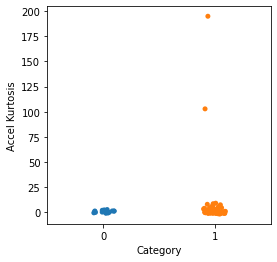

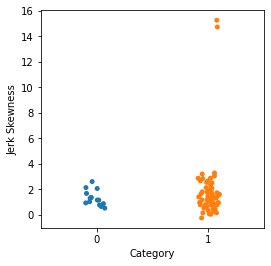

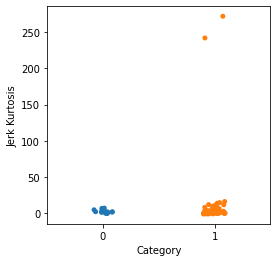

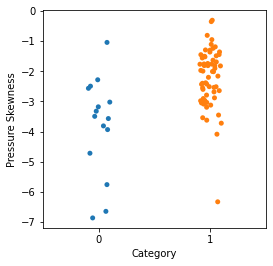

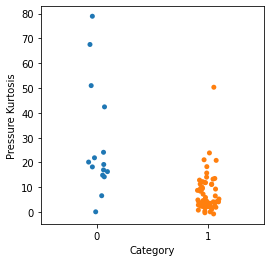

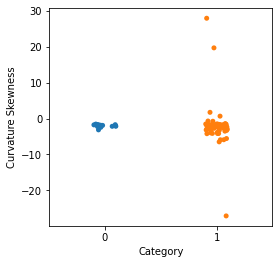

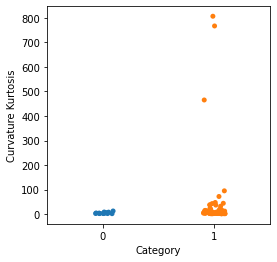

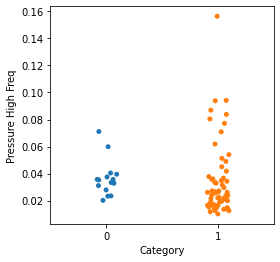

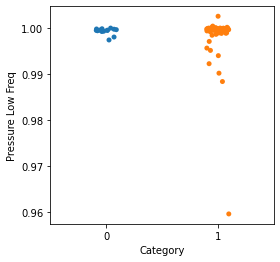

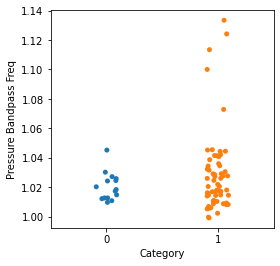

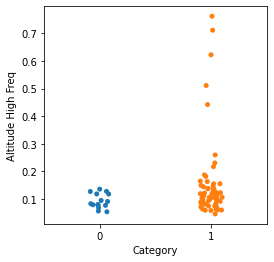

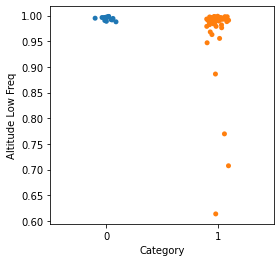

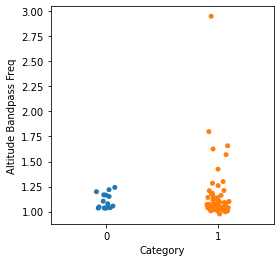

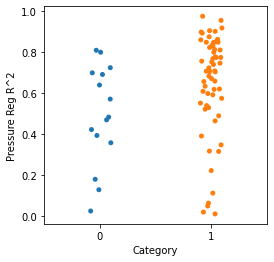

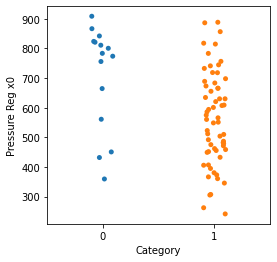

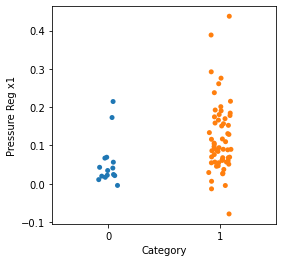

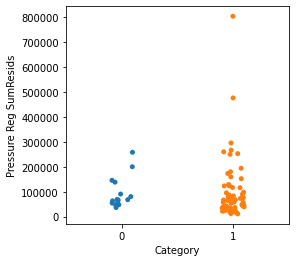

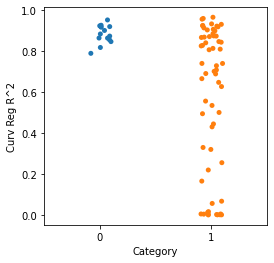

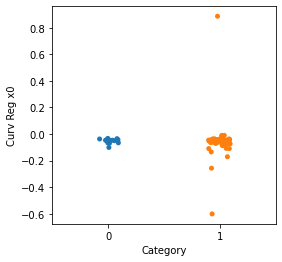

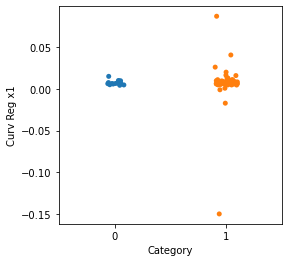

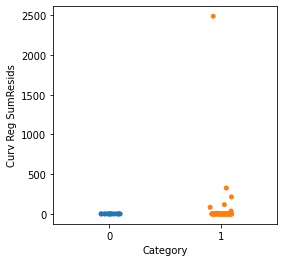

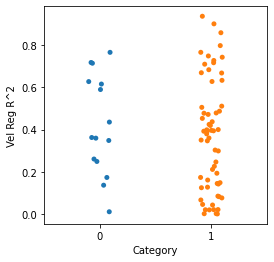

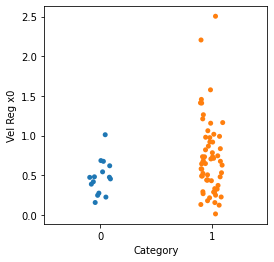

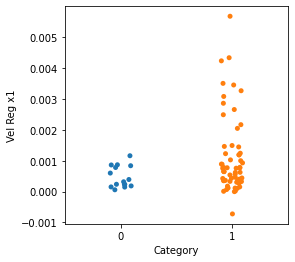

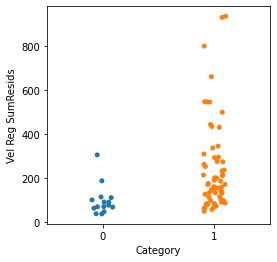

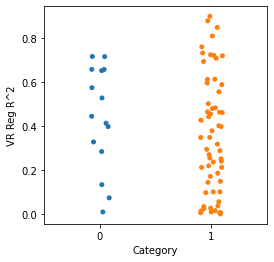

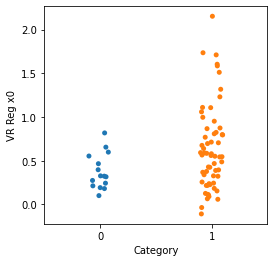

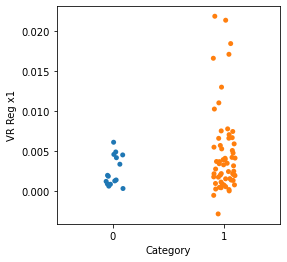

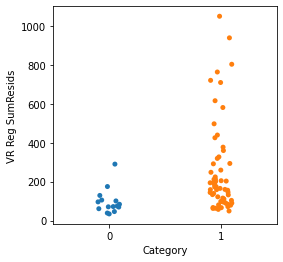

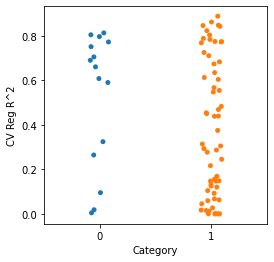

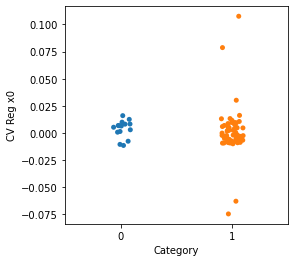

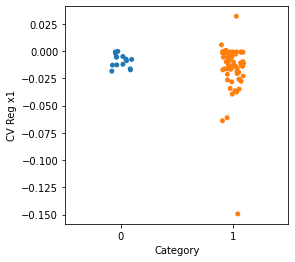

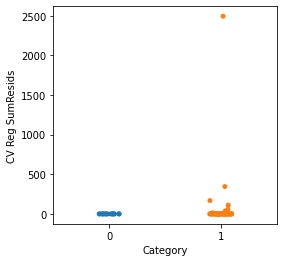

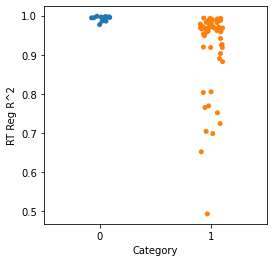

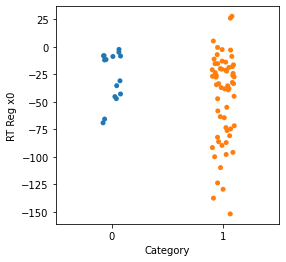

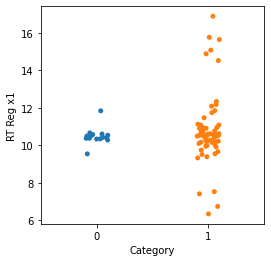

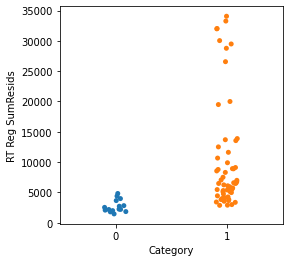

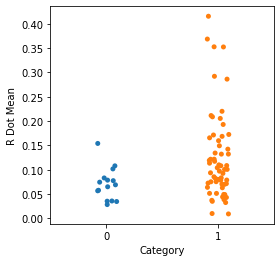

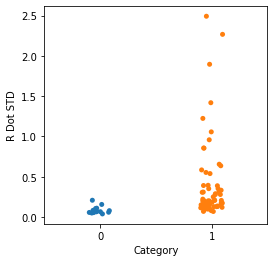

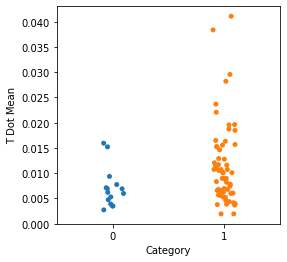

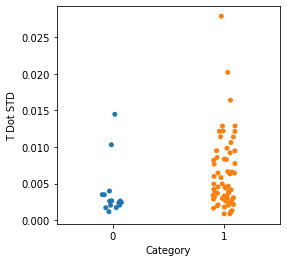

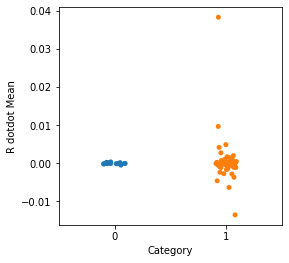

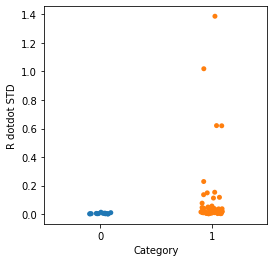

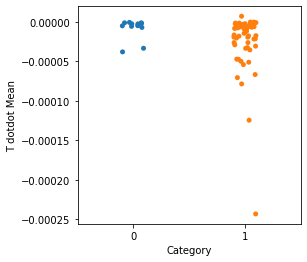

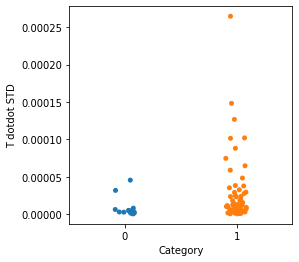

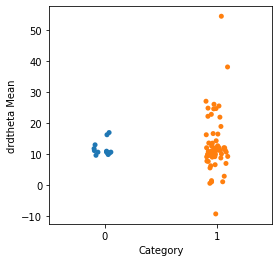

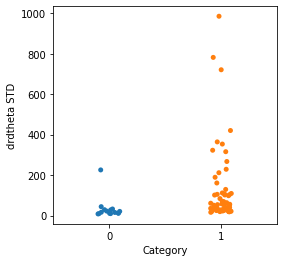

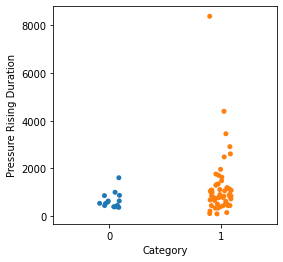

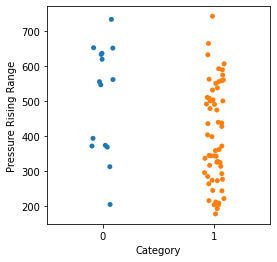

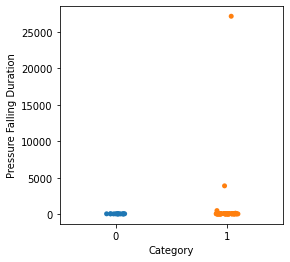

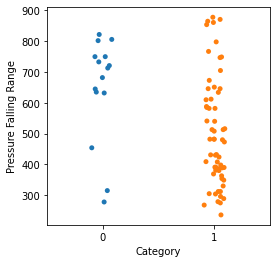

In [34]:
for i in df_all_features_static.columns[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.stripplot(x = df_all_features_static['Category'], y = df_all_features_static[i])

In [ ]:
# CALCULATE ALL DYNAMIC FEATURES AND PUT INTO DATAFRAME
'''
dynamic_subject_id = []
dynamic_category = []
dynamic_mean_vel = []
dynamic_max_vel = []
dynamic_vel_std = []
dynamic_nvv = []
dynamic_vel_niv = [] #rate
dynamic_mean_accel = []
dynamic_max_accel = []
dynamic_std_accel = []
dynamic_nia = [] #rate
dynamic_mean_jerk = []
dynamic_max_jerk = []
dynamic_std_jerk = []
dynamic_nij = [] #rate
dynamic_duration = []
dynamic_nic = []
dynamic_mean_pressure = []
dynamic_max_pressure = []
dynamic_std_pressure = []
dynamic_rate_ip = []
dynamic_x_entropy = []
dynamic_y_entropy = []
dynamic_x_skewness = []
dynamic_y_skewness = []
dynamic_x_kurtosis = []
dynamic_y_kurtosis = []
dynamic_pressure_high_freq = []
dynamic_pressure_low_freq = []
dynamic_altitude_high_freq = []
dynamic_altitude_low_freq = []
dynamic_pressure_reg_r2 = []
dynamic_pressure_reg_x0 = []
dynamic_pressure_reg_x1 = []
dynamic_pressure_reg_sumresids = []
dynamic_curv_reg_r2 = []
dynamic_curv_reg_x0 = []
dynamic_curv_reg_x1 = []
dynamic_curv_reg_sumresids = []
dynamic_vel_reg_r2 = []
dynamic_vel_reg_x0 = []
dynamic_vel_reg_x1 = []
dynamic_vel_reg_sumresids = []

dynamic_VR_reg_r2 = [] 
dynamic_VR_reg_x0 = [] 
dynamic_VR_reg_x1 = [] 
dynamic_VR_reg_sumresid = [] 
dynamic_CV_reg_r2 = [] 
dynamic_CV_reg_x0 = [] 
dynamic_CV_reg_x1 = [] 
dynamic_CV_reg_sumresids = [] 
dynamic_RT_reg_r2 = [] 
dynamic_RT_reg_x0 = [] 
dynamic_RT_reg_x1 = [] 
dynamic_RT_reg_sumresids = [] 
dynamic_rdot_mean = [] 
dynamic_rdot_std = [] 
dynamic_tdot_mean = [] 
dynamic_tdot_std = [] 
dynamic_rdotdot_mean = [] 
dynamic_rdotdot_std = [] 
dynamic_tdotdot_mean = [] 
dynamic_tdotdot_std = [] 
dynamic_drdtheta_mean = [] 
dynamic_drdtheta_std = [] 

dynamic_pressure_rising_duration = []
dynamic_pressure_rising_range = []
dynamic_pressure_falling_duration = []
dynamic_pressure_falling_range = []

for filename in controlFiles:
    print(filename)
    # retrieve all preprocessed data

    (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, 
    dynamic_acceleration, dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, 
    dynamic_drdtheta, dynamic_curvature, dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, 
    dynamic_pressure_rising, dynamic_pressure_main, dynamic_pressure_falling, dynamic_altitude) = dynamic_preprocessing(filename)

    a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1 = dynamic_calculate(filename)

    # 0 is for control in category
    dynamic_category.append(0)
    dynamic_subject_id.append(filename)
    dynamic_mean_vel.append(a)
    dynamic_max_vel.append(b)
    dynamic_vel_std.append(c)
    dynamic_nvv.append(d)
    dynamic_vel_niv.append(e) # rate
    dynamic_mean_accel.append(f)
    dynamic_max_accel.append(g)
    dynamic_std_accel.append(h)
    dynamic_nia.append(i) #rate
    dynamic_mean_jerk.append(j)
    dynamic_max_jerk.append(k)
    dynamic_std_jerk.append(l)
    dynamic_nij.append(m) #rate
    dynamic_duration.append(n)
    dynamic_nic.append(o)
    dynamic_mean_pressure.append(p)
    dynamic_max_pressure.append(q)
    dynamic_std_pressure.append(r)
    dynamic_rate_ip.append(s)
    dynamic_x_entropy.append(t)
    dynamic_y_entropy.append(u)
    dynamic_x_skewness.append(v)
    dynamic_y_skewness.append(w)
    dynamic_x_kurtosis.append(x)
    dynamic_y_kurtosis.append(y)
    dynamic_pressure_high_freq.append(z)
    dynamic_pressure_low_freq.append(a1)
    dynamic_altitude_high_freq.append(b1)
    dynamic_altitude_low_freq.append(c1)
    dynamic_pressure_reg_r2.append(d1)
    dynamic_pressure_reg_x0.append(e1)
    dynamic_pressure_reg_x1.append(f1)
    dynamic_pressure_reg_sumresids.append(g1)
    dynamic_curv_reg_r2.append(h1)
    dynamic_curv_reg_x0.append(i1)
    dynamic_curv_reg_x1.append(j1)
    dynamic_curv_reg_sumresids.append(k1)
    dynamic_vel_reg_r2.append(l1)
    dynamic_vel_reg_x0.append(m1)
    dynamic_vel_reg_x1.append(n1)
    dynamic_vel_reg_sumresids.append(o1)

    dynamic_VR_reg_r2 = [] 
    dynamic_VR_reg_x0 = [] 
    dynamic_VR_reg_x1 = [] 
    dynamic_VR_reg_sumresid = [] 
    dynamic_CV_reg_r2 = [] 
    dynamic_CV_reg_x0 = [] 
    dynamic_CV_reg_x1 = [] 
    dynamic_CV_reg_sumresids = [] 
    dynamic_RT_reg_r2 = [] 
    dynamic_RT_reg_x0 = [] 
    dynamic_RT_reg_x1 = [] 
    dynamic_RT_reg_sumresids = [] 
    dynamic_rdot_mean = [] 
    dynamic_rdot_std = [] 
    dynamic_tdot_mean = [] 
    dynamic_tdot_std = [] 
    dynamic_rdotdot_mean = [] 
    dynamic_rdotdot_std = [] 
    dynamic_tdotdot_mean = [] 
    dynamic_tdotdot_std = [] 
    dynamic_drdtheta_mean = [] 
    dynamic_drdtheta_std = [] 

    dynamic_pressure_rising_duration.append(p1)
    dynamic_pressure_rising_range.append(q1)
    dynamic_pressure_falling_duration.append(r1)
    dynamic_pressure_falling_range.append(s1)

for filename in patientFiles:
    print(filename)
    # retrieve all preprocessed data
    (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, 
    dynamic_acceleration, dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, 
    dynamic_drdtheta, dynamic_curvature, dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, 
    dynamic_pressure_rising, dynamic_pressure_main, dynamic_pressure_falling, dynamic_altitude) = dynamic_preprocessing(filename)

    a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1 = dynamic_calculate(filename)

    # 1 is for patient
    dynamic_category.append(1)
    dynamic_subject_id.append(filename)
    dynamic_mean_vel.append(a)
    dynamic_max_vel.append(b)
    dynamic_vel_std.append(c)
    dynamic_nvv.append(d)
    dynamic_vel_niv.append(e) # rate
    dynamic_mean_accel.append(f)
    dynamic_max_accel.append(g)
    dynamic_std_accel.append(h)
    dynamic_nia.append(i) #rate
    dynamic_mean_jerk.append(j)
    dynamic_max_jerk.append(k)
    dynamic_std_jerk.append(l)
    dynamic_nij.append(m) #rate
    dynamic_duration.append(n)
    dynamic_nic.append(o)
    dynamic_mean_pressure.append(p)
    dynamic_max_pressure.append(q)
    dynamic_std_pressure.append(r)
    dynamic_rate_ip.append(s)
    dynamic_x_entropy.append(t)
    dynamic_y_entropy.append(u)
    dynamic_x_skewness.append(v)
    dynamic_y_skewness.append(w)
    dynamic_x_kurtosis.append(x)
    dynamic_y_kurtosis.append(y)
    dynamic_pressure_high_freq.append(z)
    dynamic_pressure_low_freq.append(a1)
    dynamic_altitude_high_freq.append(b1)
    dynamic_altitude_low_freq.append(c1)
    dynamic_pressure_reg_r2.append(d1)
    dynamic_pressure_reg_x0.append(e1)
    dynamic_pressure_reg_x1.append(f1)
    dynamic_pressure_reg_sumresids.append(g1)
    dynamic_curv_reg_r2.append(h1)
    dynamic_curv_reg_x0.append(i1)
    dynamic_curv_reg_x1.append(j1)
    dynamic_curv_reg_sumresids.append(k1)
    dynamic_vel_reg_r2.append(l1)
    dynamic_vel_reg_x0.append(m1)
    dynamic_vel_reg_x1.append(n1)
    dynamic_vel_reg_sumresids.append(o1)
    dynamic_pressure_rising_duration.append(p1)
    dynamic_pressure_rising_range.append(q1)
    dynamic_pressure_falling_duration.append(r1)
    dynamic_pressure_falling_range.append(s1)

df_all_features_dynamic = pd.DataFrame({'Dynamic Subject ID': dynamic_subject_id, 'Category': dynamic_category,
'Mean Velocity': dynamic_mean_vel, 'Max Velocity': dynamic_max_vel, 'Velocity Std': dynamic_vel_std, 'NVV': dynamic_nvv, 'NIV': dynamic_vel_niv,
'Mean Acceleration': dynamic_mean_accel, 'Max Acceleration': dynamic_max_accel, 'Accleration Std': dynamic_std_accel, 'NIA': dynamic_nia,
'Mean Jerk': dynamic_mean_jerk, 'Max Jerk': dynamic_max_jerk, 'Jerk Std': dynamic_std_jerk, 'NIJ': dynamic_nij,
'Duration': dynamic_duration, 'NIC': dynamic_nic,
'Mean Pressure': dynamic_mean_pressure, 'Max Pressure': dynamic_max_pressure, 'Pressure Std': dynamic_std_pressure, 'Rate of Inversion in Pressure': dynamic_rate_ip,
'X Entropy': dynamic_x_entropy, 'Y Entropy': dynamic_y_entropy,
'X Skewness': dynamic_x_skewness, 'Y Skewness': dynamic_y_skewness,
'X Kurtosis': dynamic_x_kurtosis, 'Y Kurtosis': dynamic_y_kurtosis,
'Pressure High Freq': dynamic_pressure_high_freq, 'Pressure Low Freq': dynamic_pressure_low_freq,
'Altitude High Freq': dynamic_altitude_high_freq, 'Altitude Low Freq': dynamic_altitude_low_freq,
'Pressure Reg R^2': dynamic_pressure_reg_r2, 'Pressure Reg x0': dynamic_pressure_reg_x0, 'Pressure Reg x1': dynamic_pressure_reg_x1, 'Pressure Reg SumResids': dynamic_pressure_reg_sumresids,
'Curv Reg R^2': dynamic_curv_reg_r2, 'Curv Reg x0': dynamic_curv_reg_x0, 'Curv Reg x1': dynamic_curv_reg_x1, 'Curv Reg SumResids': dynamic_curv_reg_sumresids,
'Vel Reg R^2': dynamic_vel_reg_r2, 'Vel Reg x0': dynamic_vel_reg_x0, 'Vel Reg x1': dynamic_vel_reg_x1, 'Vel Reg SumResids': dynamic_vel_reg_sumresids,
'VR Reg R^2': dynamic_VR_reg_r2, 'VR Reg x0': dynamic_VR_reg_x0, 'VR Reg x1': dynamic_VR_reg_x1, 'VR Reg SumResids': dynamic_VR_reg_sumresid, 
'CV Reg R^2': dynamic_CV_reg_r2, 'CV Reg x0': dynamic_CV_reg_x0, 'CV Reg x1': dynamic_CV_reg_x1, 'CV Reg SumResids': dynamic_CV_reg_sumresid, 
'RT Reg R^2': dynamic_RT_reg_r2, 'RT Reg x0': dynamic_RT_reg_x0, 'RT Reg x1': dynamic_RT_reg_x1, 'RT Reg SumResids': dynamic_RT_reg_sumresid, 
'R Dot Mean': dynamic_rdot_mean, 'R Dot STD': dynamic_rdot_std, 'T Dot Mean': static_tdot_mean, 'T Dot STD': static_tdot_std, 
'R dotdot Mean': dynamic_rdotdot_mean, 'R dotdot STD': dynamic_rdotdot_std, 'T dotdot Mean': dynamic_tdotdot_mean, 'T dotdot STD': dynamic_tdotdot_std, 
'drdtheta Mean': dynamic_drdtheta_mean, 'drdtheta STD': dynamic_drdtheta_std, 
'Pressure Rising Duration': dynamic_pressure_rising_duration, 'Pressure Rising Range': dynamic_pressure_rising_range,
'Pressure Falling Duration': dynamic_pressure_falling_duration, 'Pressure Falling Range': dynamic_pressure_falling_range})

/work/ParkinsonHW/C_0001.txt
/work/feature_functions.py:147: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:148: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  logprob = kde.score_samples(data[:, None])
/work/feature_functions.py:147: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:148: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be re

In [ ]:
df_all_features_dynamic
filename = 'Dynamic_HW_features.csv'
df_all_features_dynamic.to_csv (filename, index = False, header=True)

In [ ]:
df_all_features_dynamic
filename = 'Dynamic_HW_features.csv'
df_all_features_dynamic.to_csv (filename, index = False, header=True)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


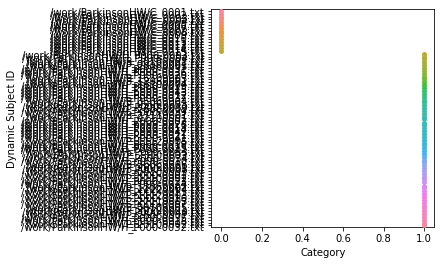

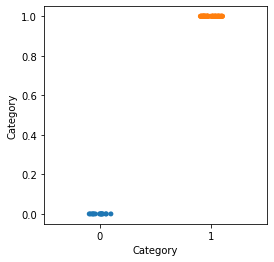

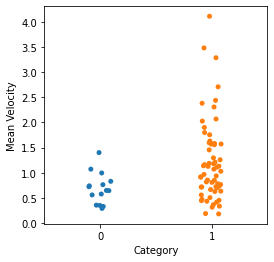

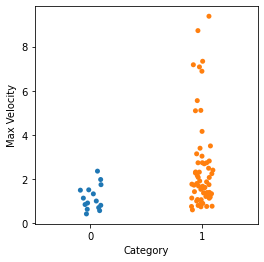

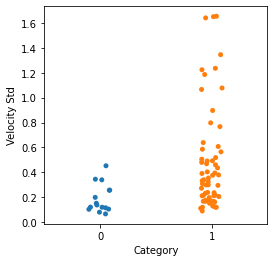

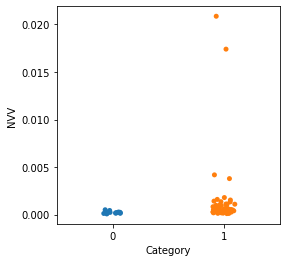

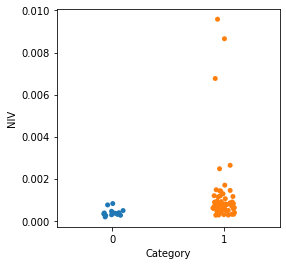

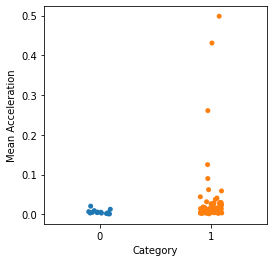

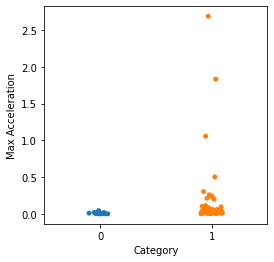

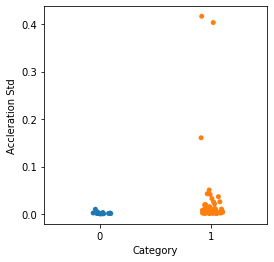

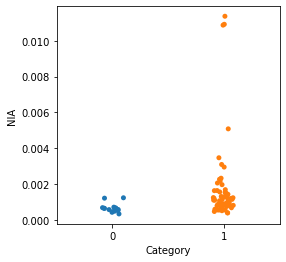

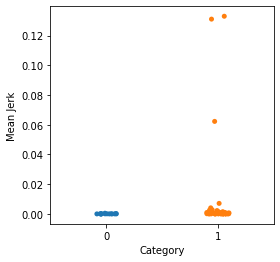

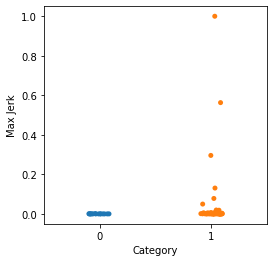

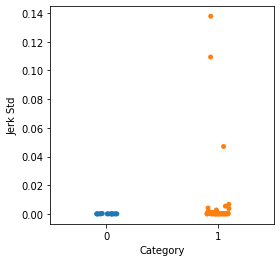

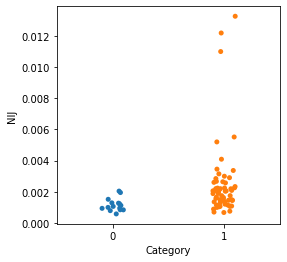

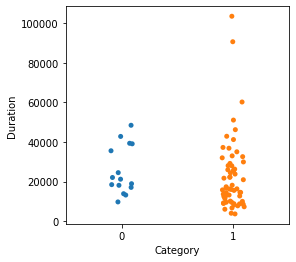

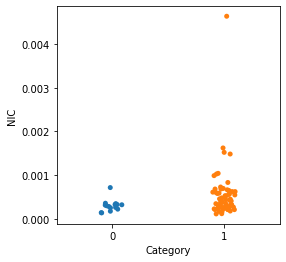

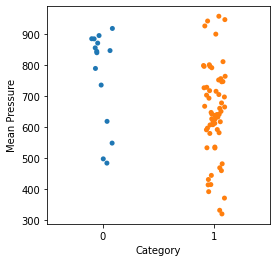

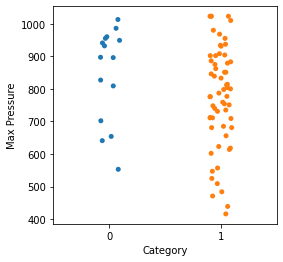

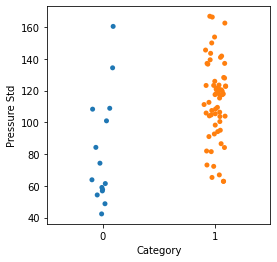

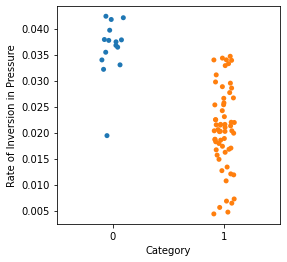

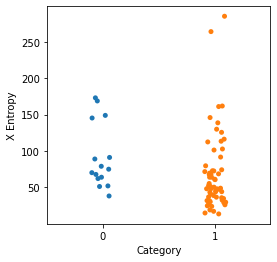

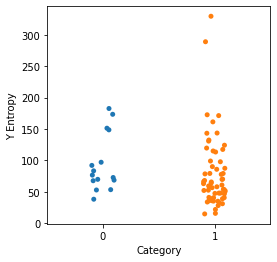

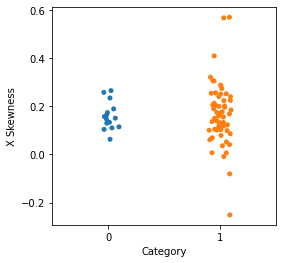

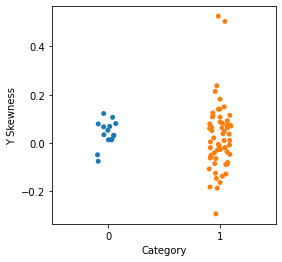

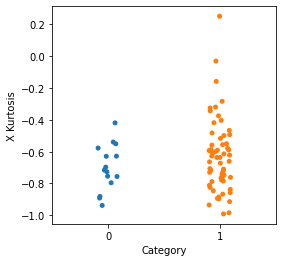

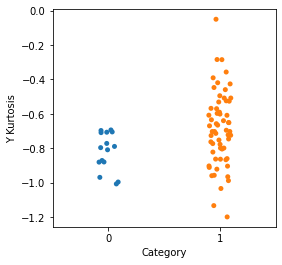

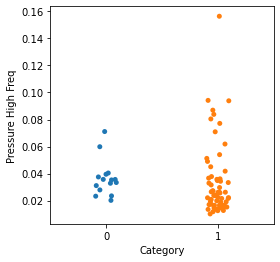

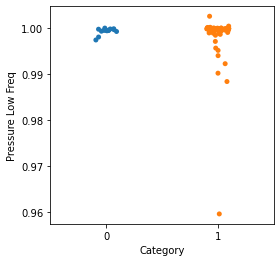

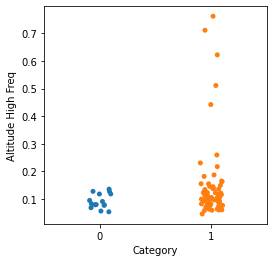

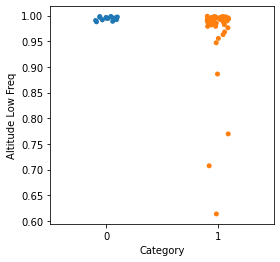

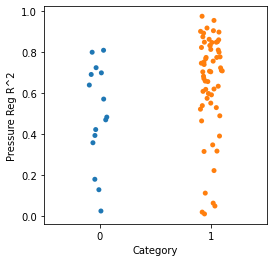

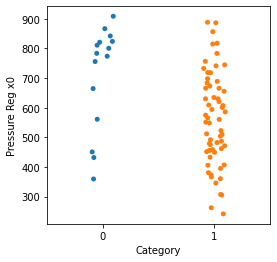

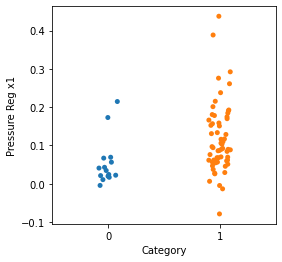

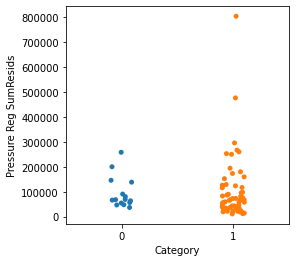

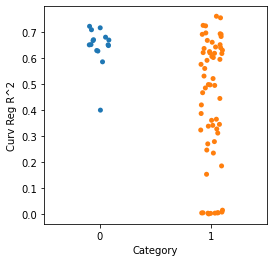

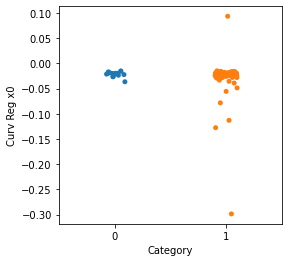

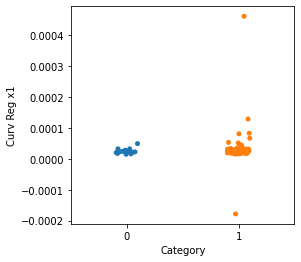

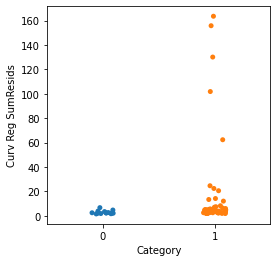

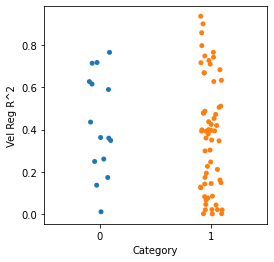

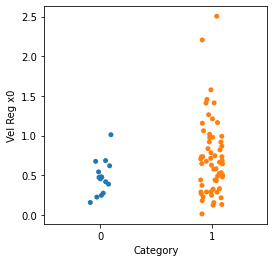

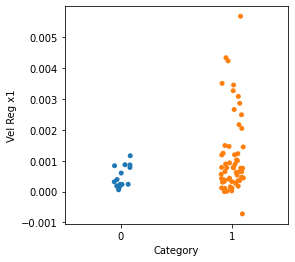

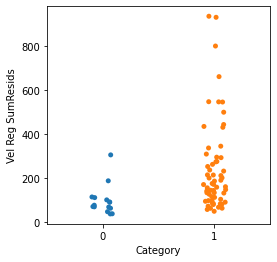

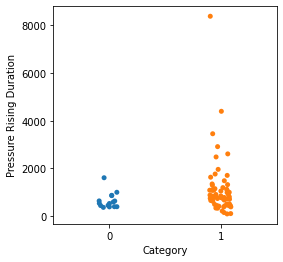

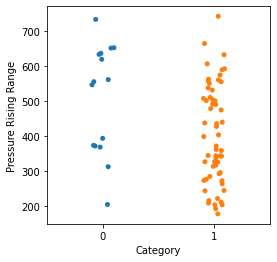

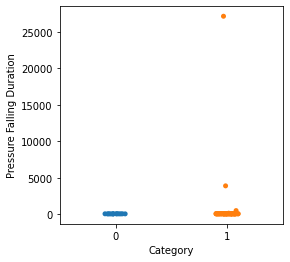

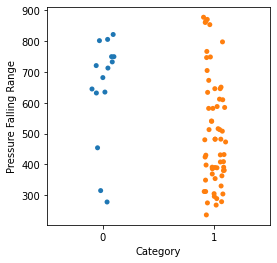

In [ ]:
for i in df_all_features_dynamic[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.stripplot(x = df_all_features_dynamic['Category'], y = df_all_features_dynamic[i])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=54ea7590-1f30-42ee-b9c1-c929b94e3f2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>